In [1]:
import sys
sys.path.append("../misc");
import onnx
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torchvision import transforms
from PIL import Image
from utils import load_class_label,extract_cifar,unpickle,fuse_single_conv_bn_pair
import torch.nn as nn
from utils import DataShaper, count_parameters
import os
import math
import numpy as np
from numpy import load
import numpy
torch.manual_seed(0)
import resnet_projected as res
import time
from brevitas.nn import QuantConv2d, QuantIdentity, QuantReLU
from brevitas.quant.fixed_point import Int8ActPerTensorFixedPoint, Int8WeightPerTensorFixedPoint,Uint8ActPerTensorFixedPoint
from brevitas.graph.target.flexml import preprocess_for_flexml_quantize
from brevitas_examples.imagenet_classification.ptq.ptq_common import quantize_model
import torch.utils.data as data_utils
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate_bn
from brevitas_examples.imagenet_classification.utils import generate_dataloader
from brevitas_examples.imagenet_classification.utils import SEED
from brevitas_examples.imagenet_classification.utils import validate
ds = DataShaper()


# LOAD THE GOLDEN MODEL
num_classes=10
offload_model=res.Resnet50OneRoof(num_classes)
weights="../misc/weights_CIFAR_CUDA_Resnet50OneRoof_0.0001_01_29_2024/CIFAR_CUDA_Resnet50OneRoof_weight_150.tar"
# offload_model=res.Resnet50ACDC(num_classes)
# weights="../misc/weights_CIFAR_Resnet50ACDC_0.0001_01_28_2024/CIFAR_Resnet50ACDC_weight_0.tar"
saved_model_dict=torch.load(weights,map_location=torch.device('cpu'))
offload_model.load_state_dict(saved_model_dict)


data_dir="data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [transforms.Pad(4), transforms.RandomHorizontalFlip(), transforms.RandomCrop(32), transforms.ToTensor()]
)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, transform=transform_test, download=True)

# Data loader
indices = torch.arange(256)
tr_sub = data_utils.Subset(train_dataset, indices)
val_sub = data_utils.Subset(test_dataset, indices)
calib_loader = torch.utils.data.DataLoader(dataset=tr_sub, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_sub, batch_size=64, shuffle=False)


# flexml requires static shapes, pass a representative input in
img_shape = 32
for name, param in offload_model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
model_aie = preprocess_for_flexml_quantize(
    offload_model.aie,
    torch.ones(1, 64, img_shape, img_shape),
    equalize_iters=1000,
    equalize_merge_bias=True,
    merge_bn=True)

quant_model = quantize_model(
        model_aie,
        backend="flexml",
        scale_factor_type="po2_scale",
        bias_bit_width=32,
        weight_bit_width=8,
        weight_narrow_range=False,
        weight_param_method="stats",
        weight_quant_granularity="per_tensor",
        weight_quant_type="sym",
        layerwise_first_last_bit_width=8,
        act_bit_width=8,
        act_param_method="stats",
        act_quant_percentile=99.999,
        act_quant_type="sym",
        quant_format="int",
        layerwise_first_last_mantissa_bit_width=4,
        layerwise_first_last_exponent_bit_width=3,
        weight_mantissa_bit_width=4,
        weight_exponent_bit_width=3,
        act_mantissa_bit_width=4,
        act_exponent_bit_width=3)

offload_model.aie=quant_model
offload_model.eval()
print("Starting activation calibration:")
calibrate(calib_loader, offload_model)
offload_model.eval()

 # Validate the quant_model on the validation dataloader
# print("Starting validation:")
# validate(val_loader, offload_model)
device, dtype = next(offload_model.parameters()).device, next(offload_model.parameters()).dtype
ref_input = torch.ones(1, 3, 32, 32, device=device, dtype=dtype)
# print(dtype)

Files already downloaded and verified
Files already downloaded and verified
Starting activation calibration:


  0%|                                                                                                         | 0/4 [00:00<?, ?it/s]C:\Users\gagan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_tensor.py:1271: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/core/TensorImpl.h:1791.)
  return super().rename(names)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.11s/it]


In [2]:
# extract scale and int weight for AIE
from numpy import load
# print("POST PTQ")
params={}
weights={}
for name, module in offload_model.named_modules():
    if isinstance(module, QuantConv2d):
        # print(name)
        # print(module.quant_weight().scale)
        weights[name + '.int_weight'] = module.quant_weight().int(float_datatype=False)
        params[name + '_scale'] = module.quant_weight().scale.detach().numpy()
    if  isinstance(module, QuantIdentity):
        # print(name)
        # print(module.quant_act_scale())
        params[name + '_scale']  = module.quant_act_scale()
    if  isinstance(module, QuantReLU):
        # print(name)
        # print(module.quant_act_scale())
        params[name + '_scale']  = module.quant_act_scale()
numpy.savez(os.path.join(os.getcwd(),'int_weights.npz'),**weights)     
numpy.savez(os.path.join(os.getcwd(),'int_conv_scale.npz'),**params) 
int_wts_data = load('int_weights.npz', allow_pickle=True)
int_scale_data = load('int_conv_scale.npz', allow_pickle=True)

# calculate proper scales for AIE
# count_parameters(offload_model)
# print(offload_model.aie)
design="bottleneck_init_conv_FINAL_cifar_complete_split_ui8_scalar"
int_wts_data_lst = int_wts_data.files
print(int_wts_data_lst)
for item in int_wts_data_lst:
    print(item)
block_0_int_weight_1=torch.from_numpy(int_wts_data["aie.layer1.conv1.int_weight"])
block_0_int_weight_2=torch.from_numpy(int_wts_data["aie.layer1.conv2.int_weight"])
block_0_int_weight_3=torch.from_numpy(int_wts_data["aie.layer1.conv3.int_weight"])
block_0_int_weights_skip=torch.from_numpy(int_wts_data["aie.layer1.shortcut.0.int_weight"])

block_1_int_weight_1=torch.from_numpy(int_wts_data["aie.layer2.conv1.int_weight"])
block_1_int_weight_2=torch.from_numpy(int_wts_data["aie.layer2.conv2.int_weight"])
block_1_int_weight_3=torch.from_numpy(int_wts_data["aie.layer2.conv3.int_weight"])

block_2_int_weight_1=torch.from_numpy(int_wts_data["aie.layer3.conv1.int_weight"])
block_2_int_weight_2=torch.from_numpy(int_wts_data["aie.layer3.conv2.int_weight"])
block_2_int_weight_3=torch.from_numpy(int_wts_data["aie.layer3.conv3.int_weight"])

int_scale_data_lst = int_scale_data.files
print(int_scale_data_lst)

init_scale =int_scale_data["aie.x_quant_scale"]
block_0_relu_1 =int_scale_data["aie.layer1.relu1_scale"]
block_0_relu_2=int_scale_data["aie.layer1.relu2_scale"]
block_0_relu_3=int_scale_data["aie.layer1.relu3_scale"]
block_0_add_scale=int_scale_data["aie.add_quant_scale"]

block_0_weight_scale_1 =int_scale_data["aie.layer1.conv1_scale"]
block_0_weight_scale_2 = int_scale_data["aie.layer1.conv2_scale"]
block_0_weight_scale_3 = int_scale_data["aie.layer1.conv3_scale"]
block_0_weight_scale_skip = int_scale_data["aie.layer1.shortcut.0_scale"]

block_1_relu_1 = int_scale_data["aie.layer2.relu1_scale"]
block_1_relu_2= int_scale_data["aie.layer2.relu2_scale"]
block_1_relu_3= int_scale_data["aie.layer2.relu3_scale"]
block_1_add_scale= int_scale_data["aie.add_1_quant_scale"]

block_1_weight_scale_1 = int_scale_data["aie.layer2.conv1_scale"]
block_1_weight_scale_2 = int_scale_data["aie.layer2.conv2_scale"]
block_1_weight_scale_3 = int_scale_data["aie.layer2.conv3_scale"]

block_2_relu_1 = int_scale_data["aie.layer3.relu1_scale"]
block_2_relu_2= int_scale_data["aie.layer3.relu2_scale"]
block_2_relu_3= int_scale_data["aie.layer3.relu3_scale"]
block_2_add_scale= int_scale_data["aie.add_2_quant_scale"]

block_2_weight_scale_1 = int_scale_data["aie.layer3.conv1_scale"]
block_2_weight_scale_2 = int_scale_data["aie.layer3.conv2_scale"]
block_2_weight_scale_3 = int_scale_data["aie.layer3.conv3_scale"]

print("_________POST PTQ SCALES_________")
print("block0 init_scale:",init_scale)
print("block0 add_scale:",block_0_add_scale)
print("block0 relu1:",block_0_relu_1)
print("block0 relu2:",block_0_relu_2)
print("block0 relu3:",block_0_relu_3)
print("_________block1_________")
print("block1 add_scale:",block_1_add_scale)
print("block1 relu1:",block_1_relu_1)
print("block1 relu2:",block_1_relu_2)
print("block1 relu3:",block_1_relu_3)
# print("block_0_weight_scale1:",block_0_weight_scale_1)
# print("block_0_weight_scale2:",block_0_weight_scale_2)
# print("block_0_weight_scale3:",block_0_weight_scale_3)
# print("block_0_weight_scale_skip:",block_0_weight_scale_skip)


print("_________MODEL SCALES_________")
for name, module in offload_model.named_modules():
        if  isinstance(module, QuantIdentity):
            print("{}:{}".format(name,module.quant_act_scale()))
for name, module in offload_model.named_modules():    
    if  isinstance(module, QuantReLU):
            print("{}:{}".format(name,module.quant_act_scale()) )        
for name, module in offload_model.named_modules():    
    if isinstance(module, QuantConv2d):
            print("{}:{}".format(name,module.quant_weight().scale))
   
   

            # params[name + '/_scale']  = module.quant_act_scale()
        
# BASE_inp_scale1 = offload_model.aie.layer1[0].x_quant.quant_act_scale()
from brevitas.export import export_onnx_qcdq
input=torch.randn(1, 64,32,32)
    # ref_input = torch.ones(1, 3, 32, 32, device="cpu", dtype=dtype)

print(offload_model.aie.graph)

for name, param in offload_model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)

   
   
block_0_combined_scale1=-math.log(init_scale*block_0_weight_scale_1/block_0_relu_1,2) #after conv1x1
block_0_combined_scale2=-math.log(block_0_relu_1*block_0_weight_scale_2/block_0_relu_2,2) #after conv3x3
block_0_combined_scale3=-math.log(block_0_relu_2*block_0_weight_scale_3/block_0_add_scale,2) #after conv1x1
block_0_combined_scale4=-math.log(block_0_add_scale/block_0_relu_3,2) #after skip addition using init scale
    # combined_scale4=-math.log(inp_scale1/inp_scale4)
block_0_combined_scale_skip=-math.log(init_scale*block_0_weight_scale_skip/block_0_add_scale,2) #after LHS conv1x1

block_1_combined_scale1=-math.log(block_0_relu_3*block_1_weight_scale_1/block_1_relu_1,2) #after conv1x1
block_1_combined_scale2=-math.log(block_1_relu_1*block_1_weight_scale_2/block_1_relu_2,2) #after conv3x3
block_1_combined_scale3=-math.log(block_1_relu_2*block_1_weight_scale_3/block_1_add_scale,2) #after conv1x1
block_1_combined_scale4=-math.log(block_1_add_scale/block_1_relu_3,2) #after skip addition using init scale

block_2_combined_scale1=-math.log(block_1_relu_3*block_2_weight_scale_1/block_2_relu_1,2) # RHS after first conv1x1 | clip 0-->255
block_2_combined_scale2=-math.log(block_2_relu_1*block_2_weight_scale_2/block_2_relu_2,2) # RHS after second conv3x3 | clip 0-->255
block_2_combined_scale3=-math.log(block_2_relu_2*block_2_weight_scale_3/block_2_add_scale,2) # RHS after third conv1x1 | clip -128-->+127
block_2_combined_scale4=-math.log(block_2_add_scale/block_2_relu_3,2) # After addition | clip 0-->255
    
print("--------------------------------------------------------------")
print("Block0 combined_scale after first conv1x1:",block_0_combined_scale1)
print("Block0 combined_scale after second conv3x3:",block_0_combined_scale2)
print("Block0 combined_scale after third conv1x1:",block_0_combined_scale3)
print("Block0 combined_scale after adding skip connection:",(block_0_combined_scale4))
print("Block0 combined_scale after skip conv1x1:",block_0_combined_scale_skip)

print("--------------------------------------------------------------")
print("Block1 combined_scale after first conv1x1:",block_1_combined_scale1)
print("Block1 combined_scale after second conv3x3:",block_1_combined_scale2)
print("Block1 combined_scale after third conv1x1:",block_1_combined_scale3)
print("Block1 combined_scale after adding skip connection:",(block_1_combined_scale4))
print("--------------------------------------------------------------")
print("combined_scale block2 after first conv1x1:",block_2_combined_scale1)
print("combined_scale block2 after second conv3x3:",block_2_combined_scale2)
print("combined_scale block2 after third conv1x1:",block_2_combined_scale3)
print("combined_scale block2 after adding skip connection:",(block_2_combined_scale4))
# print("First combined_scale block0 after adding skip connection:",(block_0_combined_scale4))

print("------------------------------------------------------------------")


['aie.layer1.conv1.int_weight', 'aie.layer1.conv2.int_weight', 'aie.layer1.conv3.int_weight', 'aie.layer1.shortcut.0.int_weight', 'aie.layer2.conv1.int_weight', 'aie.layer2.conv2.int_weight', 'aie.layer2.conv3.int_weight', 'aie.layer3.conv1.int_weight', 'aie.layer3.conv2.int_weight', 'aie.layer3.conv3.int_weight']
aie.layer1.conv1.int_weight
aie.layer1.conv2.int_weight
aie.layer1.conv3.int_weight
aie.layer1.shortcut.0.int_weight
aie.layer2.conv1.int_weight
aie.layer2.conv2.int_weight
aie.layer2.conv3.int_weight
aie.layer3.conv1.int_weight
aie.layer3.conv2.int_weight
aie.layer3.conv3.int_weight
['aie.layer1.conv1_scale', 'aie.layer1.relu1_scale', 'aie.layer1.conv2_scale', 'aie.layer1.relu2_scale', 'aie.layer1.conv3_scale', 'aie.layer1.shortcut.0_scale', 'aie.layer1.relu3_scale', 'aie.layer2.conv1_scale', 'aie.layer2.relu1_scale', 'aie.layer2.conv2_scale', 'aie.layer2.relu2_scale', 'aie.layer2.conv3_scale', 'aie.layer2.relu3_scale', 'aie.layer3.conv1_scale', 'aie.layer3.relu1_scale', 'ai

In [3]:
dtype_in  = np.dtype("int8")
dtype_wts  = np.dtype("int8")
dtype_out = np.dtype("uint8")
# 73728+69632+69632

shape_in_act   = (32,8,32,8)  #'YCXC8' , 'CYX'
shape_total_wts= (212992,1) 
shape_out      = (32,32,32,8)

trace_size = 8192
block_0_wts1 = ds.reorder_mat(block_0_int_weight_1.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block_0_wts2 = ds.reorder_mat(block_0_int_weight_2.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block_0_wts3 = ds.reorder_mat(block_0_int_weight_3.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block_0_wts_skip = ds.reorder_mat(block_0_int_weights_skip.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )

total_wts=np.concatenate((block_0_wts1,block_0_wts2,block_0_wts3,block_0_wts_skip),axis=None)

block1_wts1 = ds.reorder_mat(block_1_int_weight_1.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block1_wts2 = ds.reorder_mat(block_1_int_weight_2.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block1_wts3 = ds.reorder_mat(block_1_int_weight_3.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )


# print(bottleneck2_wts1)
total_wts2=np.concatenate((total_wts,block1_wts1,block1_wts2,block1_wts3),axis=None)

block2_wts1 = ds.reorder_mat(block_2_int_weight_1.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block2_wts2 = ds.reorder_mat(block_2_int_weight_2.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block2_wts3 = ds.reorder_mat(block_2_int_weight_3.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )

total_wts3=np.concatenate((total_wts2,block2_wts1,block2_wts2,block2_wts3),axis=None)


print("total_wts", total_wts3.shape)

design="layer_1"
log_folder="log/log_DEMO_"+design
if not os.path.exists(log_folder):
    os.makedirs(log_folder)
export_onnx_qcdq(offload_model.aie, input, log_folder+"/"+design+".onnx")
sys.path.append("../../../utils"); import xrtutils
xclbin_path = os.path.abspath("../network/"+design+"/build/final.xclbin")
insts_path  = os.path.abspath("../network/"+design+"/build/insts.txt")

cifar_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

enable_aie = True
aie_is_setup = False
app = None
in_buf = None
arg1_buf = None
out_buf = None


trace_size = 8192

def setup_aie(xclbin_path, insts_path, 
              in_0_shape, in_0_dtype,
              in_1_shape, in_1_dtype, 
              out_buf_shape, out_buf_dtype,
              enable_trace=False,
              kernel_name="MLIR_AIE"):
    app = xrtutils.AIE_Application(xclbin_path, insts_path, kernel_name)
    app.register_buffer(2, shape=in_0_shape, dtype=in_0_dtype)
    app.register_buffer(3, shape=in_1_shape, dtype=in_1_dtype)
    if enable_trace:
      out_buf_len_bytes = np.prod(out_buf_shape) * np.dtype(out_buf_dtype).itemsize
      out_buf_shape = (out_buf_len_bytes + trace_size, )
      out_buf_dtype = np.uint8
    app.register_buffer(4, shape=out_buf_shape, dtype=out_buf_dtype)
    return app

def extract_trace(out_buf, out_buf_shape, out_buf_dtype):
    trace_size_words = trace_size//4
    out_buf_flat = out_buf.reshape((-1,)).view(np.uint32)
    output_prefix = out_buf_flat[:-trace_size_words].view(out_buf_dtype).reshape(out_buf_shape)
    trace_suffix = out_buf_flat[-trace_size_words:]
    return output_prefix, trace_suffix

def write_out_trace(trace, file_name):
    out_str = "\n".join(f"{i:0{8}x}" 
                        for i in trace
                        if i != 0)
    with open(file_name, 'w') as f:
      f.write(out_str)

app = setup_aie(xclbin_path, insts_path,
                            shape_in_act, dtype_in,      
                            shape_total_wts,dtype_wts,
                            shape_out, dtype_out)


def run_on_aie(ticks, app):
    tick = time.perf_counter()
    app.run()
    tock = time.perf_counter()
    ticks.extend([tick, tock])
ticks = []

total_wts (212992,)


C:\Users\gagan\AppData\Local\Programs\Python\Python39\lib\site-packages\brevitas\export\onnx\standard\manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



____________________________________IMAGE 0____________________________________________
Time (msec): 578.03271484375
tensor(0.7500)
 Predicted AIE: truck, Predicted CPU: truck
____________________________________IMAGE 1____________________________________________
Time (msec): 593.85498046875
tensor(1.)
 Predicted AIE: truck, Predicted CPU: truck
____________________________________IMAGE 2____________________________________________
Time (msec): 662.87451171875
tensor(0.8750)
 Predicted AIE: truck, Predicted CPU: truck
____________________________________IMAGE 3____________________________________________
Time (msec): 625.558837890625
tensor(0.7500)
 Predicted AIE: truck, Predicted CPU: truck
____________________________________IMAGE 4____________________________________________
Time (msec): 618.573974609375
tensor(1.)
 Predicted AIE: automobile, Predicted CPU: automobile
____________________________________IMAGE 5____________________________________________
Time (msec): 631.912109375
t

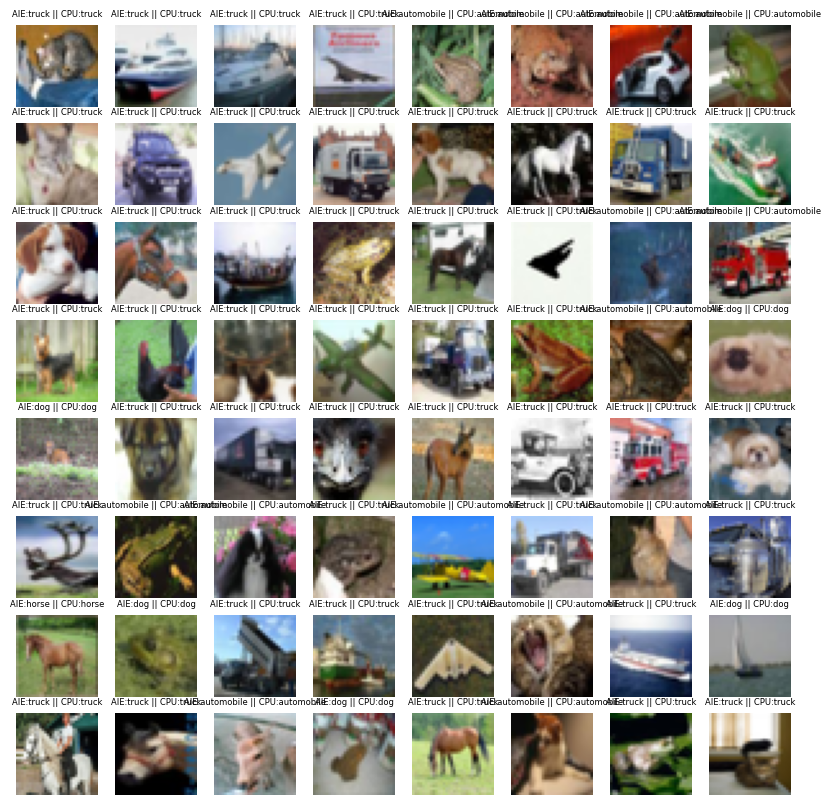

In [4]:
##### import matplotlib.pyplot as plt
import numpy as np
import time
predicted_label=[None] * 64
cpu_predicted_label=[None] * 64
# input_batch = input_tensor.unsqueeze(0)
metafile = r'./data/cifar-10-batches-py/batches.meta'
datafile = r'./data/cifar-10-batches-py/test_batch'
data_batch_1 = unpickle(datafile) 
metadata = unpickle(metafile)
labels = data_batch_1['labels']
label_path="data/cifar10_label_map.txt"
model_num_classes=10
class_label_map = load_class_label(label_path, model_num_classes)
quant_id_1 = QuantIdentity(act_quant=Uint8ActPerTensorFixedPoint,bit_width=8, return_quant_tensor=True) 
quant_id_1.eval()
for i in range (0,64): 
    print("____________________________________IMAGE {}____________________________________________".format(i))
    image_name = f'./cifar_images/image_{i}.png'
    img = Image.open(image_name)     
    input_tensor = cifar_test_transform(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        # print(input_batch.shape
        start = time.time() * 1000
        output1 = offload_model.first(input_batch)

        # AIE OFFLOAD
        qnt_inp = offload_model.aie.x_quant(output1)
        int_inp = offload_model.aie.x_quant(output1).int(float_datatype=True)
        before_input=int_inp.squeeze().data.numpy().astype(dtype_in)
        ifm_mem_fmt = ds.reorder_mat(before_input,'YCXC8' , 'CYX' )
        app.buffers[2].write(ifm_mem_fmt)# input's standard format CYX | scalar YCX
        app.buffers[3].write(total_wts3) # wts's standard format OIYX | scalar OIYX
        
        app.run()
        
        
        output_aie= app.buffers[4].read()*block_2_relu_3
 
        temp_out    = output_aie.reshape(32,32,32,8)
        temp2_out   = ds.reorder_mat( temp_out, 'CDYX','YCXD' )
        ofm_mem_fmt = temp2_out.reshape(256,32,32)
        
        
        
        ofm_mem_fmt=torch.from_numpy(ofm_mem_fmt).unsqueeze(0)
        final_output_aie = offload_model.post(ofm_mem_fmt)
        end = time.time() * 1000
        print("Time (msec):",end - start)
        # output_aie_scaled=output_aie*block_1_relu_3
        # temp_out=output_aie_scaled.reshape(32,256, 32)
        # ofm_mem_fmt = temp_out.swapaxes(0,1) 

        # ------------------------------------------------------------------------------
        # Baseline output for functional correctness  
        output_golden = offload_model.aie(output1)
        # print(type(ofm_mem_fmt))
        # print(type(output_golden))
        max_error=(torch.max(torch.abs(ofm_mem_fmt - output_golden)))
        print(max_error)
        # print("AIE::",ofm_mem_fmt)
        # print("GOLDEN::",output_golden)
        # assert(np.allclose(ofm_mem_fmt, output_golden, rtol=0, atol=3*block_1_relu_3))
        # ------------------------------------------------------------------------------    

        
        final_output_base = offload_model.post(output_golden)
        
        predicted_class = np.argmax(final_output_aie)
        predicted_label[i] = metadata['label_names'][predicted_class]

        cpu_predicted_class = np.argmax(final_output_base)
        cpu_predicted_label[i] = metadata['label_names'][cpu_predicted_class]

        label = metadata['label_names'][labels[i]]
        print(f' Predicted AIE: {predicted_label[i]}, Predicted CPU: {cpu_predicted_label[i]}') 

        
        # Calculate the five categories with the highest classification probability
        prediction_class_index = torch.topk(final_output_aie, k=5, sorted=True).indices.squeeze(0).tolist()
        golden_prediction_class_index = torch.topk(final_output_base, k=5, sorted=True).indices.squeeze(0).tolist()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8,figsize=(10,10))
for i, ax in enumerate(axs.flat):
    img = Image.open("./cifar_images/image_"+str(i)+".png")
    ax.imshow(img)
    ax.axis('off')  # to hide the axes
    ax.set_title("AIE:"+predicted_label[i]+" || CPU:"+predicted_label[i],fontsize=6)

    